## Benettin, Shimada, Nagashima algorithm for lyapunov exponent spectrum

Pseudocode from [here](https://www.cambridge.org/core/journals/anziam-journal/article/lyapunov-exponents-of-the-kuramotosivashinsky-pde/FE2E4CBD4AAFC9BE25C7453AD6FB2575), see page 6.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import sys
sys.path.insert(0, '..')
# from reservoirpy import ESN
from typing import Tuple
from scipy.integrate import solve_ivp

In /opt/anaconda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/anaconda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle

## Lyapunov exponents of Lorenz system

In [2]:
# function for simulating Lorenz systems

from typing import Tuple
from scipy.integrate import solve_ivp


def lorenz(n_timesteps: int, state0: list=[1.0, 1.0, 1.0], 
           rho: float=28.0, sigma: float=10.0, beta: float=8.0/3.0, h: float=0.01) -> Tuple[np.ndarray, np.ndarray]:
    def lorenz_diff(t, state):
        x, y, z = state
        return sigma * (y - x), x * (rho - z) - y, x * y - beta * z
    
    t = np.arange(0, (n_timesteps+1) * h, h)
    
    sol = solve_ivp(lorenz_diff, 
                    y0=state0, 
                    t_span=(0.0, (n_timesteps+1)*h),
                    dense_output=True)
    
    return sol.sol(t).T[-1, :]

In [4]:
# calculate lyapunov specturm for lorenz system

def qr_pos(Q, R):
    sgn = np.sign(np.diag(R))
    R_new = np.diag(sgn).dot(R)
    Q_new = Q.dot(np.diag(sgn))
    return Q_new, R_new


##
tau = 10000        # number of initial timesteps
N = 1000           # total number of renormalizations
T = 20            # number of timesteps between renormalizations
m = 3             # number of exponents to compute
eps = 0.000001      # perturbation magnitude

dim = 3
log_r = 0

timestep = 0.01


# compute u(0)
u0 = lorenz(tau, [0.2, 3, 4], h = timestep)
u_prev = u0
# choose initial orthogonal directions
Q0 = np.diag(np.ones(dim))
#Q0 = np.random.random((3,3))
Q_prev = Q0

# for total N renormalizations
for j in range(N):
    # compute uj = u(tj)
    uj = lorenz(T, u_prev, h = timestep)
    
    # for m lyapunov exponents/directions
    Phi_Q = np.zeros((dim, dim))
    for i in range(m):
        w = lorenz(T, u_prev + eps*Q_prev[:, i], h = timestep)
        Phi_Q[:, i] = (w-uj)/eps

    Q, R = np.linalg.qr(Phi_Q)  ### Q, R decomposition. Q is a matrix with orthonomrla columns.
    Q, R = qr_pos(Q, R)
    log_r = log_r + np.log(np.diag(R))
    
    u_prev = uj
    Q_prev = Q
    

# calculate (and print) the exponents    
log_r/(N*T*timestep)

array([  0.90937935,   0.02260339, -14.40868124])

## Lyapunov exponents of Kuramoto-Sivashinsky system


Text(0.5, 1.0, 'Kuramoto-Sivashinsky: L = 22, nu = 1')

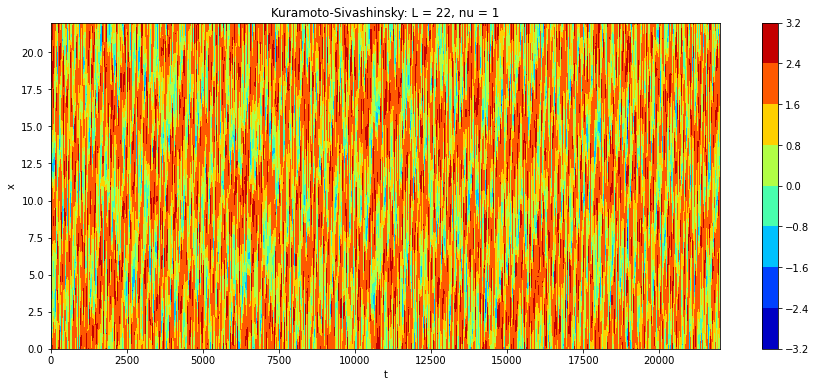

In [5]:
# simulating data from K-S and plotting it

from matplotlib.pyplot import cm
# nu = 1
# L = 35 
# nx = 64

# t0 = 0 
# tN = 20200
# dt = 0.25#0.13   #0.05
# nt = int((tN - t0) / dt)


nu = 1
L = 22
nx = 64   # L 19 nx 64

t0 = 0 
tN = 22000
dt = 0.25#0.13   #0.05
nt = int((tN - t0) / dt)


# wave number meshz
k = np.arange(-nx/2, nx/2, 1)

t = np.linspace(start=t0, stop=tN, num=nt)
x = np.linspace(start=0, stop=L, num=nx)

# solution mesh in real space
u = np.ones((nx, nt))
# solution mesh in Fourier space
u_hat = np.ones((nx, nt), dtype=complex)

u_hat2 = np.ones((nx, nt), dtype=complex)

# initial condition 
#u0 = np.cos((2 * np.pi * x) / L) + 0.2 * np.cos((4 * np.pi * x) / L)
u0 = np.cos((2 * np.pi * x) / L) + 0.2 * np.cos((4 * np.pi * x) / L)


# Fourier transform of initial condition
u0_hat = (1 / nx) * np.fft.fftshift(np.fft.fft(u0))

u0_hat2 = (1 / nx) * np.fft.fftshift(np.fft.fft(u0**2))

# set initial condition in real and Fourier mesh
u[:,0] = u0
u_hat[:,0] = u0_hat

u_hat2[:,0] = u0_hat2

# Fourier Transform of the linear operator
FL = (((2 * np.pi) / L) * k) ** 2 - nu * (((2 * np.pi) / L) * k) ** 4
# Fourier Transform of the non-linear operator
FN = - (1 / 2) * ((1j) * ((2 * np.pi) / L) * k)

# resolve EDP in Fourier space
for j in range(0,nt-1):
  uhat_current = u_hat[:,j]
  uhat_current2 = u_hat2[:,j]
  if j == 0:
    uhat_last = u_hat[:,0]
    uhat_last2 = u_hat2[:,0]
  else:
    uhat_last = u_hat[:,j-1]
    uhat_last2 = u_hat2[:,j-1]
  
  # compute solution in Fourier space through a finite difference method
  # Cranck-Nicholson + Adam 
  u_hat[:,j+1] = (1 / (1 - (dt / 2) * FL)) * ( (1 + (dt / 2) * FL) * uhat_current + ( ((3 / 2) * FN) * (uhat_current2) - ((1 / 2) * FN) * (uhat_last2) ) * dt )
  # go back in real space
  u[:,j+1] = np.real(nx * np.fft.ifft(np.fft.ifftshift(u_hat[:,j+1])))

  # clean the imaginary part contribution in u_hat
  u_hat[:,j+1] = (1 / nx) * np.fft.fftshift(np.fft.fft(u[:,j+1]))

  u_hat2[:,j+1] = (1 / nx) * np.fft.fftshift(np.fft.fft(u[:,j+1]**2))

# plot the result
fig, ax = plt.subplots(figsize=(15,6))

xx, tt = np.meshgrid(t, x)
levels = np.arange(-3, 3, 0.01)
cs = ax.contourf(xx, tt, u, cmap=cm.jet)
fig.colorbar(cs)

ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_title(f"Kuramoto-Sivashinsky: L = {L}, nu = {nu}")

In [6]:
# function for simulating K-S

def ks(n_timesteps, u0, L=35, nx=64, dt=0.25):
    nt = n_timesteps +1

    # wave number meshz
    k = np.arange(-nx/2, nx/2, 1)
    t0 = 0
    tN = nt*dt
    t = np.linspace(start=t0, stop=tN, num=nt)
    x = np.linspace(start=0, stop=L, num=nx)

    # solution mesh in real space
    u = np.ones((nx, nt))
    # solution mesh in Fourier space
    u_hat = np.ones((nx, nt), dtype=complex)
    u_hat2 = np.ones((nx, nt), dtype=complex)

    # Fourier transform of initial condition
    u0_hat = (1 / nx) * np.fft.fftshift(np.fft.fft(u0))
    u0_hat2 = (1 / nx) * np.fft.fftshift(np.fft.fft(u0**2))

    # set initial condition in real and Fourier mesh
    u[:,0] = u0
    u_hat[:,0] = u0_hat
    u_hat2[:,0] = u0_hat2

    nu = 1
    # Fourier Transform of the linear operator
    FL = (((2 * np.pi) / L) * k) ** 2 - nu * (((2 * np.pi) / L) * k) ** 4
    # Fourier Transform of the non-linear operator
    FN = - (1 / 2) * ((1j) * ((2 * np.pi) / L) * k)

    # resolve EDP in Fourier space
    for j in range(0,nt-1):
      uhat_current = u_hat[:,j]
      uhat_current2 = u_hat2[:,j]
      if j == 0:
        uhat_last = u_hat[:,0]
        uhat_last2 = u_hat2[:,0]
      else:
        uhat_last = u_hat[:,j-1]
        uhat_last2 = u_hat2[:,j-1]

      # compute solution in Fourier space through a finite difference method
      # Cranck-Nicholson + Adam 
      u_hat[:,j+1] = (1 / (1 - (dt / 2) * FL)) * ( (1 + (dt / 2) * FL) * uhat_current + ( ((3 / 2) * FN) * (uhat_current2) - ((1 / 2) * FN) * (uhat_last2) ) * dt )
      # go back in real space
      u[:,j+1] = np.real(nx * np.fft.ifft(np.fft.ifftshift(u_hat[:,j+1])))

      # clean the imaginary part contribution in u_hat
      u_hat[:,j+1] = (1 / nx) * np.fft.fftshift(np.fft.fft(u[:,j+1]))
      u_hat2[:,j+1] = (1 / nx) * np.fft.fftshift(np.fft.fft(u[:,j+1]**2))

    return u.T[-1, :]

In [7]:
# function for simulating inhomogenous K-S

def ks2(n_timesteps, u0, L=35, nx=64, dt=0.25):
    nt = n_timesteps +1

    # wave number meshz
    k = np.arange(-nx/2, nx/2, 1)
    t0 = 0
    tN = nt*dt
    t = np.linspace(start=t0, stop=tN, num=nt)
    x = np.linspace(start=0, stop=L, num=nx)
    
    mu = 0.1
    lam = 7
    L_per_lam = int(L/lam)

    # solution mesh in real space
    u = np.ones((nx, nt))
    # solution mesh in Fourier space
    u_hat = np.ones((nx, nt), dtype=complex)
    u_hat2 = np.ones((nx, nt), dtype=complex)

    # Fourier transform of initial condition
    u0_hat = (1 / nx) * np.fft.fftshift(np.fft.fft(u0))
    u0_hat2 = (1 / nx) * np.fft.fftshift(np.fft.fft(u0**2))

    # set initial condition in real and Fourier mesh
    u[:,0] = u0
    u_hat[:,0] = u0_hat
    u_hat2[:,0] = u0_hat2

    nu = 1
    # Fourier Transform of the linear operator
    FL = (((2 * np.pi) / L) * k) ** 2 - nu * (((2 * np.pi) / L) * k) ** 4
    # Fourier Transform of the non-linear operator
    FN = - (1 / 2) * ((1j) * ((2 * np.pi) / L) * k)
    
    M = mu * ((((2 * np.pi) / L) * k) ** 2 )/2

    # resolve EDP in Fourier space
    for j in range(0,nt-1):
      uhat_current = u_hat[:,j]
      uhat_current2 = u_hat2[:,j]
      if j == 0:
        uhat_last = u_hat[:,0]
        uhat_last2 = u_hat2[:,0]
      else:
        uhat_last = u_hat[:,j-1]
        uhat_last2 = u_hat2[:,j-1]

      # inhomogenity term, 2-step Adam-Bashforth:
      iht = ( (3/2)*M*(np.roll(uhat_current, -L_per_lam) + np.roll(uhat_current,L_per_lam)) -(1/2)*M*(np.roll(uhat_last, -L_per_lam) + np.roll(uhat_last,L_per_lam))) * dt
    
      # compute solution in Fourier space through a finite difference method
      # Cranck-Nicholson + Adam 
      u_hat[:,j+1] = (1 / (1 - (dt / 2) * FL)) * ( (1 + (dt / 2) * FL) * uhat_current + ( ((3 / 2) * FN) * (uhat_current2) - ((1 / 2) * FN) * (uhat_last2) ) * dt +iht  )
      # go back in real space
      u[:,j+1] = np.real(nx * np.fft.ifft(np.fft.ifftshift(u_hat[:,j+1])))

      # clean the imaginary part contribution in u_hat
      u_hat[:,j+1] = (1 / nx) * np.fft.fftshift(np.fft.fft(u[:,j+1]))
      u_hat2[:,j+1] = (1 / nx) * np.fft.fftshift(np.fft.fft(u[:,j+1]**2))

    return u.T[-1, :]

(64, 64)
0
100
200
300
400
500
600
700
800
900


array([ 7.99094215e-02,  5.88309469e-02,  3.01203830e-02,  1.46708231e-02,
        3.69105459e-03,  6.10026084e-04, -4.48128341e-03, -1.44257252e-02,
       -4.60907486e-02, -8.46099459e-02, -1.40208805e-01, -2.08258102e-01,
       -2.56123412e-01, -3.05496258e-01, -3.43103383e-01, -3.90357514e-01,
       -4.43381335e-01, -4.78206086e-01, -5.00923707e-01, -1.36915747e+00,
       -1.38217909e+00, -2.68841356e+00, -2.68960517e+00, -4.42005386e+00,
       -4.42008693e+00, -6.70368165e+00, -6.70370491e+00, -9.59347745e+00,
       -9.71801135e+00, -9.87939072e+00, -1.00027026e+01, -1.00831997e+01,
       -1.01327277e+01, -1.01671700e+01, -1.01955168e+01, -1.02267680e+01,
       -1.02526624e+01, -1.02707176e+01, -1.02936622e+01, -1.03129716e+01,
       -1.03318435e+01, -1.03499018e+01, -1.03707073e+01, -1.03888252e+01,
       -1.04099796e+01, -1.04298125e+01, -1.04494945e+01, -1.04776599e+01,
       -1.04952431e+01, -1.05250586e+01, -1.05514357e+01, -1.05707732e+01,
       -1.05944922e+01, -

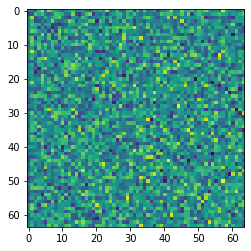

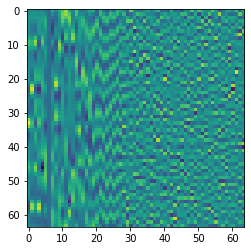

In [8]:
# calculating Lyapunov spectrum for K-S 
# can take some time (>15 min)

def qr_pos(Q, R):
    sgn = np.sign(np.diag(R))
    R_new = np.diag(sgn).dot(R)
    Q_new = Q.dot(np.diag(sgn))
    return Q_new, R_new


##
tau = 50000        # number of initial timesteps
N = 1000           # total number of renormalizations
T = 200            # number of timesteps between renormalizations
m = 64             # number of exponents to compute
eps = 0.000001      # perturbation magnitude

dim = 64
log_r = 0

timestep = 0.01
L = 46

# points on which K-S is calculated, [0, L]
nx = 64
x = np.linspace(start=0, stop=L, num=nx)

# initial condition 
u0_ = np.cos((2 * np.pi * x) / L) + 0.2 * np.cos((4 * np.pi * x) / L)

# compute u(0), simulating K-S for tau initial timesteps 
u0 = ks(tau, u0_, L=L, dt = timestep, nx=dim)
u_prev = u0

# choose initial orthogonal directions
#Q0 = np.diag(np.ones(dim))
Q0_ = np.random.random((dim, m))
Q0, R = np.linalg.qr(Q0_)
Q_prev = Q0

print(Q0_.shape)

plt.figure()
plt.imshow(Q0)

# for total N renormalizations
for j in range(N):
    if j%100==0:
        print(j)
    
    # compute uj = u(tj)
    uj = ks(T, u_prev, L=L, dt = timestep, nx=dim)
    
    # for m lyapunov exponents/directions
    Phi_Q = np.zeros((dim, m))
    for i in range(m):
        w = ks(T, u_prev + eps*Q_prev[:, i], L=L, dt = timestep,nx=dim )
        Phi_Q[:, i] = (w-uj)/eps

    Q, R = np.linalg.qr(Phi_Q)  ### Q, R decomposition. Q is a matrix with orthonormal columns.
    Q, R = qr_pos(Q, R)
    log_r = log_r + np.log(np.diag(R))
    
    u_prev = uj
    Q_prev = Q

plt.figure()
plt.imshow(Q)

# print the exponents
log_r/(N*T*timestep)

In [9]:
def kaplan_yorke(lyevec):
    lysum = 0
    i=0
    while lysum >= 0:
        lysum = lysum + lyevec[i]
        i=i+1    
    return i-1 + (lysum - lyevec[i-1])/np.abs(lyevec[i-1])

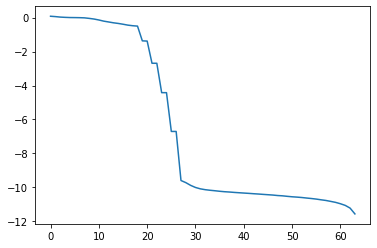

In [10]:
lyes_L46 = log_r/(N*T*timestep)
plt.plot(lyes_L46)

In [11]:
kaplan_yorke(lyes_L46)

10.272628755451638